In [1]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
import gc

gc.collect()

12

In [2]:
weight_tuning=1
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            init.uniform_(self.weight, -bound,bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [3]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [4]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

# mean-squared error loss
criterion = nn.MSELoss()

#print(model.encoder_input_layer.weight)

cuda


In [6]:
import matplotlib.pyplot as plt 
epochs=5000
asymptotic_repetition=150


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,50
spectral_calculation=5
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [7]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.ones(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            if result.cpu().detach().numpy()<2**-52:
                result=torch.Tensor([2**-52]).to(device)
            temp=result
            diff*=result**(1/no_of_image)
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
        if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
            diff=torch.Tensor([1*10**38]).to(device)
            #    print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=torch.Tensor([2**-52]).to(device)

        distance.append(diff.cpu().detach().numpy())

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



running


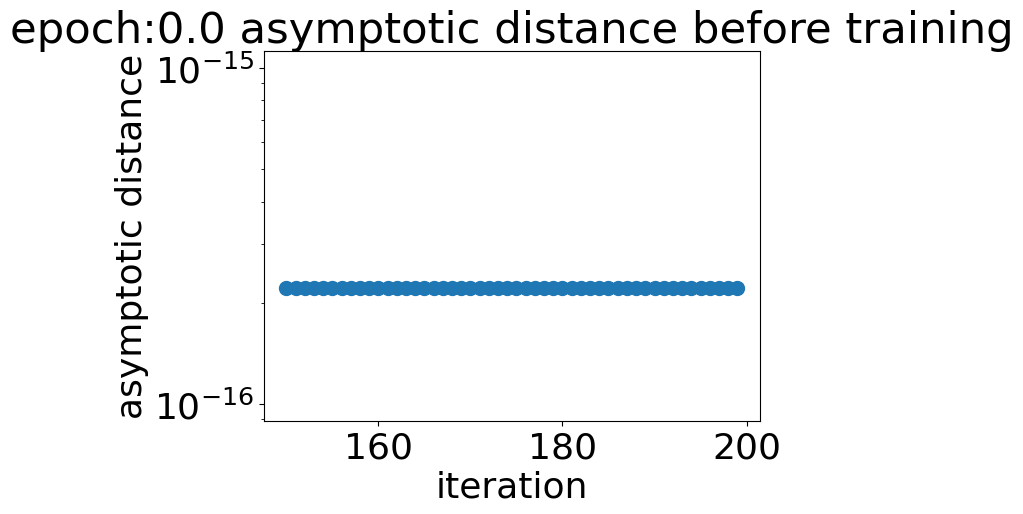

epoch : 1/5000, training loss = 0.197664,validation loss = 0.194778
epoch : 2/5000, training loss = 0.190737,validation loss = 0.185797
epoch : 3/5000, training loss = 0.178089,validation loss = 0.168333
epoch : 4/5000, training loss = 0.153555,validation loss = 0.135739
epoch : 5/5000, training loss = 0.125391,validation loss = 0.119374
epoch : 6/5000, training loss = 0.117554,validation loss = 0.116141
epoch : 7/5000, training loss = 0.115545,validation loss = 0.114614
epoch : 8/5000, training loss = 0.114291,validation loss = 0.113708
epoch : 9/5000, training loss = 0.113587,validation loss = 0.112963
epoch : 10/5000, training loss = 0.112695,validation loss = 0.112048
epoch : 11/5000, training loss = 0.111803,validation loss = 0.111251
epoch : 12/5000, training loss = 0.111256,validation loss = 0.110958
epoch : 13/5000, training loss = 0.111039,validation loss = 0.110781
epoch : 14/5000, training loss = 0.110838,validation loss = 0.110309
epoch : 15/5000, training loss = 0.110057,v

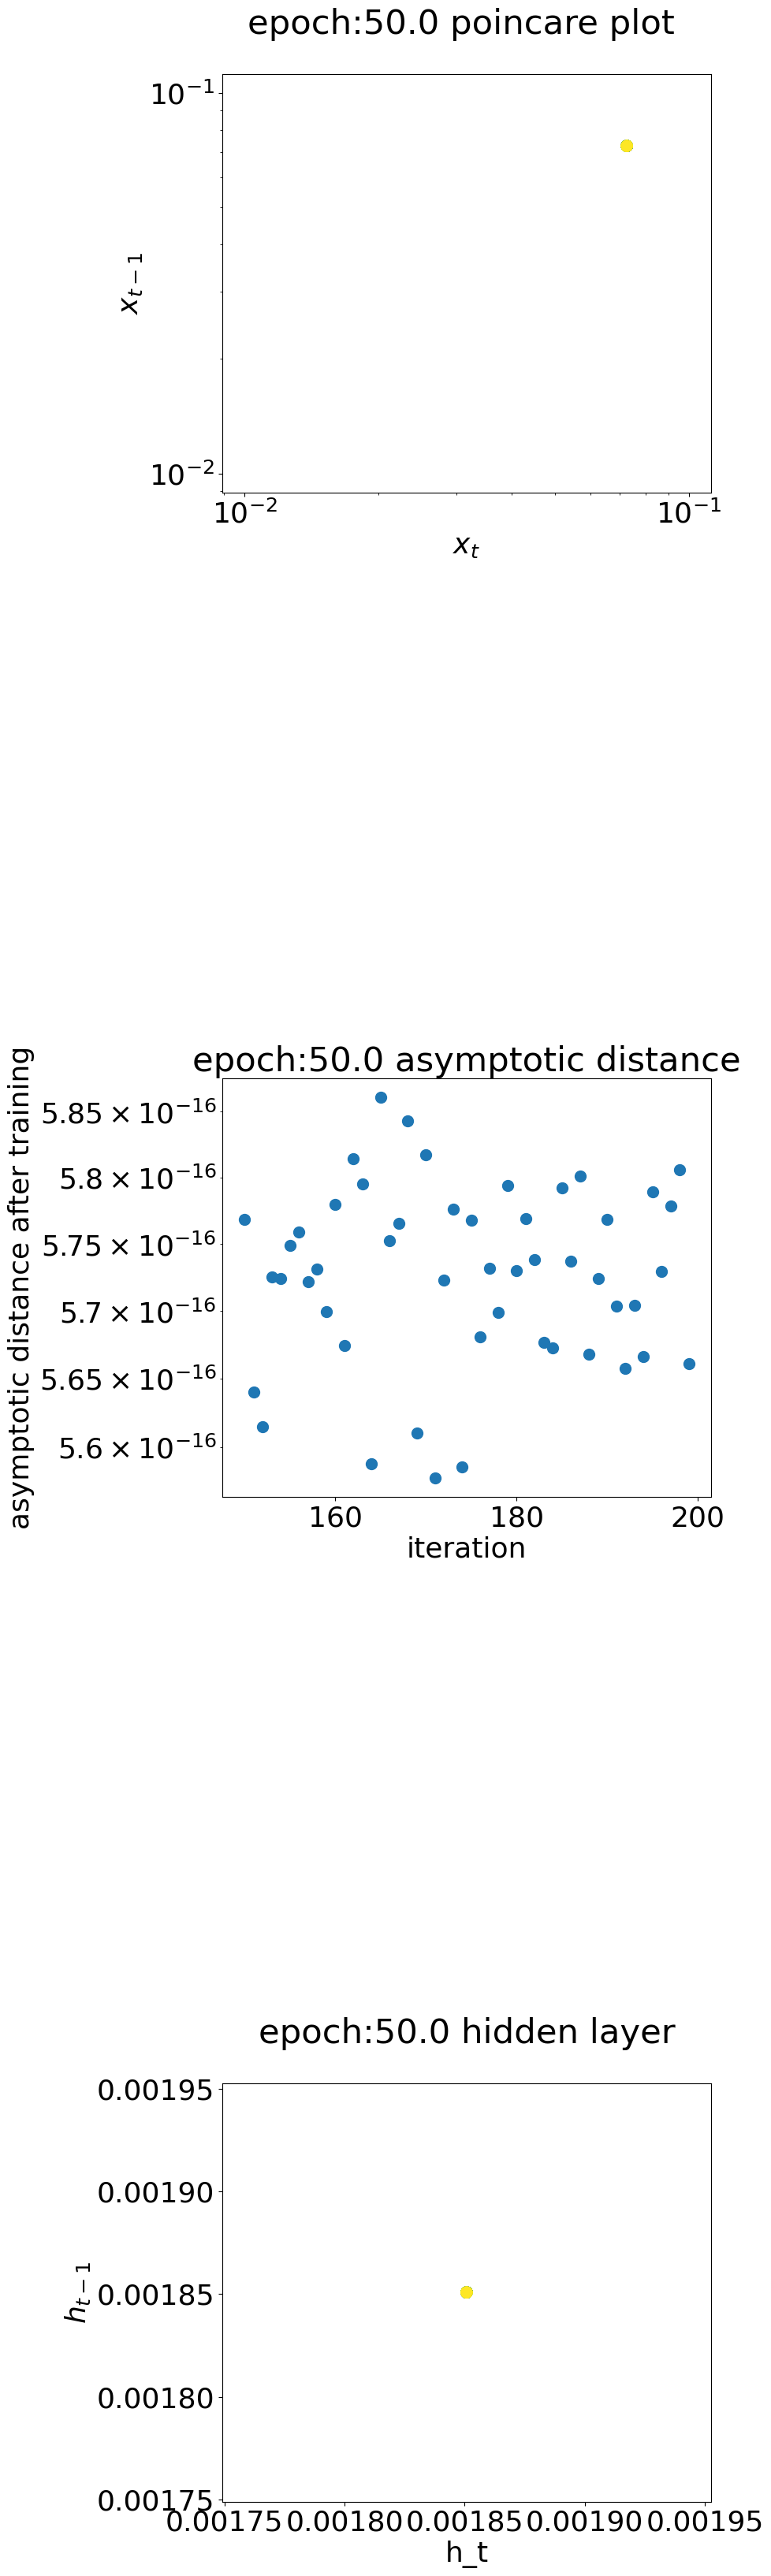

epoch : 51/5000, training loss = 0.104157,validation loss = 0.103934
epoch : 52/5000, training loss = 0.104093,validation loss = 0.103868
epoch : 53/5000, training loss = 0.104004,validation loss = 0.103738
epoch : 54/5000, training loss = 0.103851,validation loss = 0.103611
epoch : 55/5000, training loss = 0.103721,validation loss = 0.103413
epoch : 56/5000, training loss = 0.103559,validation loss = 0.103320
epoch : 57/5000, training loss = 0.103471,validation loss = 0.103231
epoch : 58/5000, training loss = 0.103378,validation loss = 0.103132
epoch : 59/5000, training loss = 0.103272,validation loss = 0.103008
epoch : 60/5000, training loss = 0.103138,validation loss = 0.102877
epoch : 61/5000, training loss = 0.102979,validation loss = 0.102602
epoch : 62/5000, training loss = 0.102178,validation loss = 0.101401
epoch : 63/5000, training loss = 0.101376,validation loss = 0.101036
epoch : 64/5000, training loss = 0.101132,validation loss = 0.100804
epoch : 65/5000, training loss = 0

In [ ]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
#diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=True
chao=[]
noise_print=False
for epoch in range(epochs):
    loss = 0


    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        batch_feature=batch_features.view(batch_size,-1)
        #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature.to(device))
        
        if init_compute==True and epoch%interval==0:
            torch.save(model.state_dict(), "epoch:"+str(epoch)+".pt")
                #print("here")Trues 
                #print(train_loss)
            save_image=input_image
                #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
            perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
                #print("perturbed_inputs")
                #print(torch.norm(perturbed_inputs))
            cutoff=[]
            for j in range(no_of_images):
                cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
            model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer)
            model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
            #model_clone.eval() 
            #print(cutoff)
            x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
            x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
            #print("there")
            ##print(torch.norm(y_pred_perturbed))
            #print(torch.norm(y_pred_unperturbed))
            distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
                
            asymptotic_dist.append(distance[-1])
            chao.append(chaos)
            
            plt.scatter(x=np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),y=distance,s=100)
            plt.xlabel("iteration")
            plt.ylabel("asymptotic distance")
            plt.yscale("log")
            plt.title("epoch:{:.1f} asymptotic distance before training".format(epoch))
            np.savetxt("asymptotic distance"+str(epoch)+".txt",distance)
            plt.savefig("initial asymptotic state.jpg")
            plt.show()
            #average_jacobian=[]
            #spectral_radiuses=[]
            init_compute=False
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)

    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
        
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        #dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train_unperturbed[0],dimension_vector,no_of_repetition,colour,epoch)
        #name="asymptotic image input"
#         #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
#         #x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
        perturbed_input=add_gaussian_noise(save_image,perturbation_strength)
        cutoffs=[]
        for j in range(no_of_images):
            cutoffs.append(torch.norm(perturbed_input[j]-save_image[j]))
        #print(cutoffs)
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_input,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,save_image,epoch)
        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoffs)
                

        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train_perturbed[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
         #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
     
       
         #perturbed_inputs=add_powerlaw_noise(input_size,batch_size,perturbation_strength,x_train.cpu()).view(batch_size, -1).to(device)
         #distance,hidden,chaos=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
        print("percentage of chaos:",chaos) 
        
        asymptotic_dist.append(distance[-1])
         #print(distance[-1])
        inits=0
        if epoch==epochs-1:
            for value in model.parameters():
                 #print(key)
                plots=torch.flatten(value).cpu().detach().numpy()
                plt.hist(plots, density=True, bins='auto', histtype='stepfilled',cumulative=-1)
                 #plt.title("model "+str(key)+"plot")
                plt.savefig("model "+str(inits)+"plot.jpg")
                np.savetxt("fianl weight"+str(inits)+".txt",value.cpu().detach().numpy())
                plt.show()
                inits+=1
        
        
        chao.append(chaos)
         #diverge.append(divergent/100)
        

        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        plt.xscale("log")
        plt.yscale("log")
        
        plt.subplot(5, 1, 3)
        plt.scatter(np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance after training")
        np.savetxt("asymptotic distance"+str(epoch+1),distance)
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("h_t")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+".jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)



In [ ]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)

print(chao)
font = {
        'size'   : 14}
plt.rc('font', **font)

intervals=50
x=np.arange(1,epochs/intervals+2)
xx=np.arange(1,epochs/intervals+1)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao[0:61],label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()









print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist[0:61],label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",)

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

#print("average jacobian")
#plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("average jacobian")
#plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("average_jacobian.jpg")
#np.savetxt("average jacobian.txt",average_jacobian)
#plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
plt.show()
#print("asymptotic distance")
plot_loss=[]
for i in range(len(validation_loss)):
    if i%intervals==0:
        plot_loss.append(validation_loss[i])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch/'+str(intervals))
ax1.set_ylabel('validation loss', color=color)
ax1.scatter(xx,y=plot_loss[0:60], label="validation loss",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('asymptotic distance', color=color)  # we already handled the x-label with ax1
ax2.scatter(x,y=asymptotic_dist[0:61], color=color,label="asymptotic distance")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.scatter(xx,plot_loss[0:60],label="validation loss")
        
        
        
#plt.plot(x,plot_loss,label="validation loss")
plt.scatter(x,y=asymptotic_dist[0:61],label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

plt.plot(validation_loss)
plt.yscale("log")
plt.show()
plt.plot(training_loss)
plt.yscale("log")
plt.show()